In [1]:
import numpy as np
from joblib import load
from pathlib import Path
from xspec import AllModels, AllData, Model, Plot
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

from modules.network import r_squared

2024-02-15 22:16:38.866506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 22:16:38.866794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 22:16:38.932619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 22:16:39.110617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 22:16:40.222661: W tensorflow/compiler/tf2

In [2]:
# Set up paths for logs and models
cwd = Path.cwd()
path_to_logs = Path(cwd / "logs")
path_to_samples = Path(cwd / "samples")

fluxes = []

model_name = "TBabs*(rdblur*rfxconv*comptb + diskbb + comptb)"

sample_scaled = np.load(path_to_samples / 'complete_sample.npy')
relevant_par =  np.load(path_to_samples / "relevant_par.npy")

# Invert the log10 of these components
log_index = [0, 9, 12]
for i in range(sample_scaled.shape[0]):
    for j in log_index:
        sample_scaled[i, j] =  pow(10, sample_scaled[i, j])
        
# Iterate through scaled samples to set up and save models
for index, params in enumerate(sample_scaled):
    
    # Clear existing XSPEC models and data
    AllModels.clear()
    AllData.clear()
    AllData.dummyrsp(0.5, 20.)

    # Initialize the model
    m = Model(model_name)

    # Changing default frozen parameters to unfrozen
    m.rdblur.Betor10.frozen = False
    m.rdblur.Rout_M.frozen = True
    m.rdblur.Rin_M.frozen = False
    m.rfxconv.Fe_abund.frozen = False
    m.comptb.gamma.frozen = True
    m.comptb.delta.frozen = True
    m.comptb.log_A.frozen = True

    m.rdblur.Rout_M.values = 1000
    m.comptb.delta.values = 0
    m.comptb.log_A.values = 8

    m.rfxconv.cosIncl.link = "COSD(5)"
    # Linking comptb_6 (refletion) parameters to comptb (comptb)
    start = 20  # Number of the first parameter of comptb_6
    for i in range(start, start + len(m.comptb_6.parameterNames)):
        m(i).link = str(i-9) # 9 is the separation between comptb and comptb_6

    # Add the model to the spectral analysis system and set parameters
    AllModels.setPars(m, {int(relevant_par[j]):params[j] for j in range(len(relevant_par))})

    # Set up the energy range of interest for plotting
    Plot.device = "/null"
    Plot.xAxis = "keV"
    Plot.show()
    Plot('model')
    energy = Plot.x()
    flux = Plot.model()
    fluxes.append(flux)

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.


Compton reflection from ionized medium.
If you use results from this model in a paper
please refer to Chris Done

Model TBabs<1>(rdblur<2>*rfxconv<3>*comptb<4> + diskbb<5> + comptb<6>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   rdblur     Betor10             -2.00000     frozen
   3    2   rdblur     Rin_M               10.0000      frozen
   4    2   rdblur     Rout_M              1000.00      frozen
   5    2   rdblur     Incl       deg      30.0000      +/-  0.0          
   6    3   rfxconv    rel_refl            -1.00000     +/-  0.0          
   7    3   rfxconv    redshift            0.0          frozen
   8    3   rfxconv    Fe_abund            1.00000      frozen
   9    3   rfxconv    cosIncl             0.500000     frozen
  10    3   rfxconv    log_xi              1.00000      +/-  0.0          
  11    4   comptb     kTs        keV      1.00000

In [3]:
data = 'models_0.5-20_100k_smooth_2'
cwd = Path.cwd()
path_to_logs = cwd / 'logs'
path_to_data = cwd / 'data' / data
path_to_results = cwd / 'results'
#result_dir = path_to_results / 'ANN' / '100k' / 'batchnorm' / 'drop_0.3' /'lr_1e-4' / '256x4_500e'
result_dir = path_to_results / 'GRU' / '100k_smooth_2' / '128x6'
model_file_path = result_dir / 'GRU_model.h5'

# Load the model
model = load_model(model_file_path, custom_objects={'r_squared': r_squared})
# Load the saved scaler
flux_scaler = load(path_to_data / 'flux_scaler.joblib')
predicted = []

for par in sample_scaled:
    # Make predictions
    log_index = [0, 9, 12]
    for i in log_index:
        par[i] = np.log10(par[i])
    prediction = model.predict(par.reshape(-1, par.shape[0]))
    flux_predicted = flux_scaler.inverse_transform(prediction)
    predicted.append(flux_predicted)
    

1/1 [==============================] - 0s 18ms/step


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 13, 128)           50304     
                                                                 
 gru_1 (GRU)                 (None, 13, 128)           99072     
                                                                 
 gru_2 (GRU)                 (None, 13, 128)           99072     
                                                                 
 gru_3 (GRU)                 (None, 13, 128)           99072     
                                                                 
 gru_4 (GRU)                 (None, 13, 128)           99072     
                                                                 
 gru_5 (GRU)                 (None, 13, 128)           99072     
                                                                 
 gru_6 (GRU)                 (None, 13, 128)           9

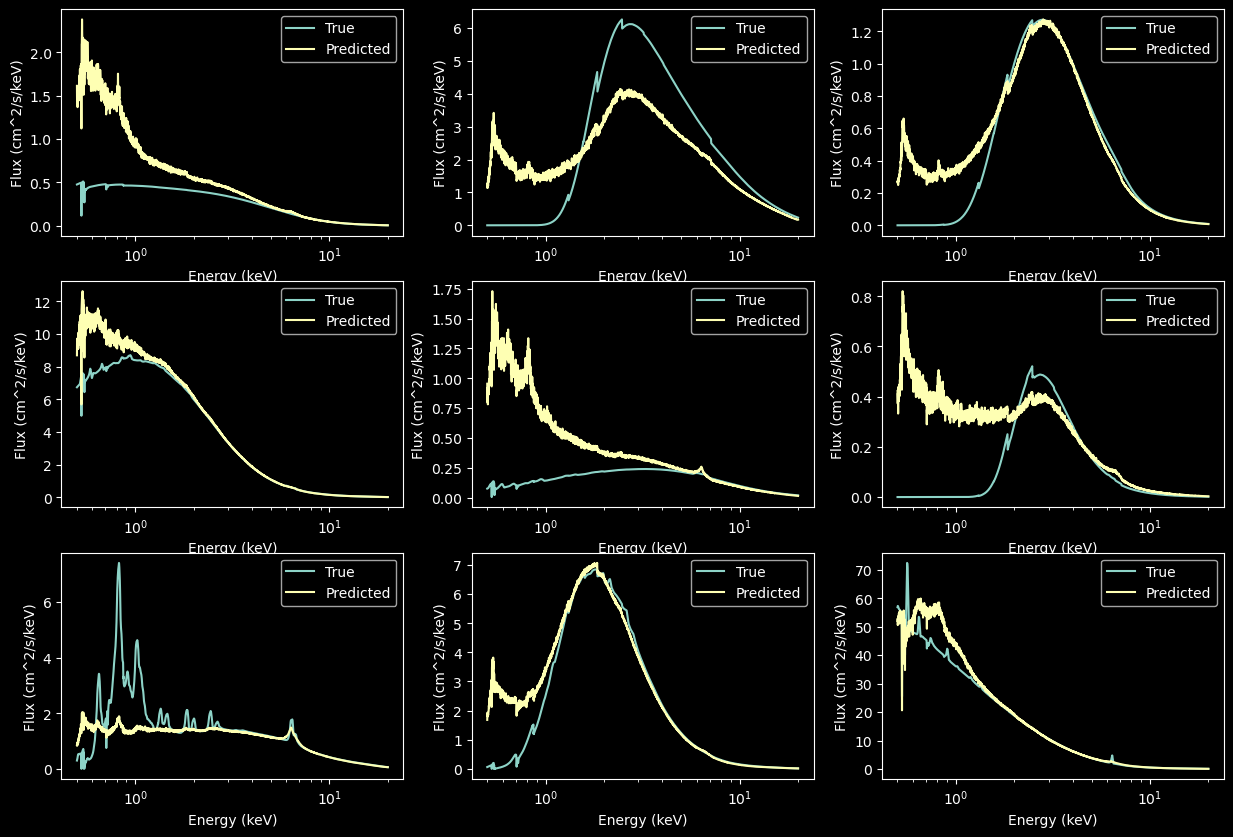

In [5]:
n_points = 2
# Create subplots for the selected number of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for idx, true_flux in enumerate(fluxes):
    
    # Calculate the row and column index for the subplot
    row_index = idx // 3
    col_index = idx % 3
    
    if n_points:
        energy_reshape = (np.array(energy).reshape(-1, n_points).mean(axis=1)).tolist()
        true_flux_reshape = (np.array(true_flux).reshape(-1, n_points).mean(axis=1)).tolist()
    else:
        energy_reshape = energy
        true_flux_reshape = true_flux
    # Plot the data on the corresponding subplot
    axes[row_index, col_index].plot(energy_reshape, true_flux_reshape, label="True")
    axes[row_index, col_index].plot(energy_reshape, predicted[idx][0], label='Predicted')
    axes[row_index, col_index].set_xlabel('Energy (keV)')
    axes[row_index, col_index].set_xscale('log')
    axes[row_index, col_index].set_ylabel('Flux (cm^2/s/keV)')
    axes[row_index, col_index].legend()